In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
import scispacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, classification_report, ConfusionMatrixDisplay
from mord import OrdinalRidge
from sklearn.model_selection import GridSearchCV

# model explanations
import lime
from lime.lime_text import LimeTextExplainer
import shap

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
def read_data(path_to_csv_file, delimiter=None):
    '''
    Reads csv file from specified path
    '''
    df = pd.read_csv(path_to_csv_file, delimiter=delimiter)
    
    return df

# call function to import data - UPDATE PATH TO RUN CODE
df_patient = read_data('/Users/mncedisimncwabe/Downloads/patient_behavior_data.csv',delimiter=";")
df_patient.head()

,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15mg,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects...
1,2,Other,NaN,NaN,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed. Ye...
2,3,Male,Vyvanse,15mg,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up. Both set T...
3,4,Female,NaN,5mg,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30mg,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite. Large sig...


### 1. Preprocess notes: tokenise, lemmatise, remove stopwords.

In [5]:
# Install en_core_web_sm using:
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.0/en_core_web_sm-3.7.0-py3-none-any.whl

In [8]:
def clean_clinical_notes(text):
    """
    Keep only the first coherent sentence from doctor notes.
    Removes all text after the first period followed by space and capital letter.
    """
    if pd.isna(text):
        return ""
    
    # Find the first sentence-ending period followed by space and capital letter
    match = re.search(r'\.\s+[A-Z]', str(text))
    
    if match:
        return text[:match.start()+1].strip()
    else:
        return str(text).strip()

patient_df_clean = df_patient.copy()
patient_df_clean['doctor_notes'] = patient_df_clean['doctor_notes'].apply(clean_clinical_notes)
patient_df_clean[['patient_id','doctor_notes']].head()

,patient_id,doctor_notes
0,1,Needs review of medication due to side effects.
1,2,No significant behavioral changes observed.
2,3,Mood swings noted during follow-up.
3,4,Increased talkativeness and interrupting behav...
4,5,Significant improvement in appetite.


In [9]:
# Load spaCy's English model
nlp_spacy = spacy.load('en_core_web_sm')

# Keep some custom medical terms stopwords 
MEDICAL_STOPWORDS = {'patient', 'history', 'normal', 'exam', 'physical', 'day', 'week', 'month', 'year', 'status', 'note', 'findings'}
STOP_WORDS.update(MEDICAL_STOPWORDS)

def remove_emojis_special_chars(text):
    """Remove emojis and special characters from text"""
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF" 
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002500-\U00002BEF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\u2640-\u2642" 
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    
    text = re.sub(r'[^\w\s.,!?]', '', text)
    return emoji_pattern.sub(r'', text)

def preprocess_text(text):
    """
    Preprocess clinical notes by:
    1. Removing emojis/special characters
    2. Tokenizing
    3. Lemmatizing 
    4. Removing stopwords (while preserving medical terms)
    """
    if pd.isna(text):
        return ""
    
    # lower case text
    cleaned_text = remove_emojis_special_chars(str(text).lower())
    
    # tokenization 
    doc = nlp_spacy(cleaned_text)
    
    processed_tokens = []
    for token in doc: 
        if (not token.is_punct and 
            not token.is_space and 
            (not token.is_stop or token.text in MEDICAL_STOPWORDS)):
            
            # lemmatization
            lemma = token.lemma_.strip().lower()
            if lemma:  
                processed_tokens.append(lemma)
    
    return " ".join(processed_tokens)

patient_df_processed = patient_df_clean.copy()
patient_df_processed['processed_notes'] = patient_df_processed['doctor_notes'].apply(preprocess_text)
patient_df_processed[['patient_id','doctor_notes','processed_notes']].head()

,patient_id,doctor_notes,processed_notes
0,1,Needs review of medication due to side effects.,need review medication effect
1,2,No significant behavioral changes observed.,significant behavioral change observe
2,3,Mood swings noted during follow-up.,mood swing note followup
3,4,Increased talkativeness and interrupting behav...,increase talkativeness interrupt behavior
4,5,Significant improvement in appetite.,significant improvement appetite


### 2. Use NER (spaCy or scispaCy) to extract medical terms.

In [12]:
# Install BC5CDR model (chemical/disease NER)
# pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz

# Load the BC5CDR model (chemical/disease NER)
nlp = spacy.load("en_ner_bc5cdr_md")

def extract_medical_entities(text, visualize=False):
    """
    Extract medical entities using scispacy BC5CDR model
    """
    if pd.isna(text) or not str(text).strip():
        return {'terms': "", 'details': []}
    
    doc = nlp(str(text))
    entities = []
    details = []
    
    for ent in doc.ents:
        entities.append(ent.text)
        details.append((ent.text, ent.label_, ent.start_char, ent.end_char))

    if visualize and doc:
        displacy.render(doc[:400], style='ent', jupyter=True)
    
    return {'terms': " | ".join(set(entities)), 'details': details}

medical_entities = patient_df_processed['processed_notes'].apply(extract_medical_entities)
patient_df_processed['medical_terms'] = medical_entities.apply(lambda x: x['terms'])
patient_df_processed['medical_entities'] = medical_entities.apply(lambda x: x['details'])

# Visualize
extract_medical_entities(patient_df_processed['doctor_notes'].iloc[298], visualize=True)
patient_df_processed[['doctor_notes','processed_notes', 'medical_terms', 'medical_entities']].tail()

,doctor_notes,processed_notes,medical_terms,medical_entities
19994,Unable to maintain focus during assessments.,unable maintain focus assessment,,[]
19995,Low energy levels and persistent fatigue obser...,low energy level persistent fatigue observe,fatigue,"[(fatigue, DISEASE, 28, 35)]"
19996,Hyperactivity levels slightly reduced.,hyperactivity level slightly reduce,hyperactivity,"[(hyperactivity, DISEASE, 0, 13)]"
19997,Patient is cooperative and responsive.,patient cooperative responsive,,[]
19998,Mood swings noted during follow-up.,mood swing note followup,,[]


### 3. Train a model to classify mood from doctor_notes (baseline + explanation).
- Use TF-IDF + Logistic Regression
- Visualise important words using LIME or SHAP


#### Insights
- The target variable mood ratings is ordinal data type (-2 to 2), therefore models for ordinal data can be best suited 

##### Important features/words from model
- Positive moods (2) are associated with improved appetite ("significant improvement appetite") and reduced hyperactivity ("level slightly reduce")
- Neutral moods (0-1): show more medication adjustments ("dosage change")
- Negative moods (-1): correlate with social withdrawal features ("appears withdran and less communicative") and increased hyperactivity
- The models have low accuracy whcih indicates they struggles to reliably predict mood classes. Text-based models often need larger volumes of text data and may need deeper NLP preprocessing.
- For production purpose I'd also try more advanced feature engineering such as transformer-based models (e.g BERT) which understand semantic meaning of a text, but kept it at TF-IDF for the scope of this assessment. 
- For prod I'd also invest in data quality and advanced modeling techniques to improve accuracy, but this serves as a POC with much room for improvement.
- As noted from EDA as well, there is no string relationship between the features on this data, hence the model is not accurate. In production, more data would be needed to accurately predict mood.

In [13]:
def prepare_for_modeling(df):
    vectorizer = TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 3),
        min_df=3,                      
        max_df=0.85,                   
        stop_words='english',
        analyzer='word',
        use_idf=True,
        sublinear_tf=True
    )
    # Fit and transform
    X = vectorizer.fit_transform(df['processed_notes'])
    y = df['mood']
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Convert to DataFrame while preserving sparsity
    if sparse.issparse(X):
        X_df = pd.DataFrame.sparse.from_spmatrix(X, columns=feature_names)
    else:
        X_df = pd.DataFrame(X, columns=feature_names)
    
    return X_df, y, vectorizer, feature_names

X, y, vectorizer, feature_names = prepare_for_modeling(patient_df_processed)
X.head()

,activity,answer,answer inappropriately,appear,appear distracted,appear distracted fidgety,appear suppress,appear suppress visit,appear withdraw,appear withdraw communicative,appetite,appetite appear,appetite appear suppress,assessment,behavior,behavioral,behavioral change,behavioral change observe,blurt,blurt answer,blurt answer inappropriately,change,change observe,class,class activity,communicative,complain,complain frequent,complain frequent headache,concentration,concentration dosage,concentration dosage change,cooperative,cooperative responsive,difficulty,difficulty follow,difficulty follow multistep,distracted,distracted fidgety,dosage,dosage change,effect,energy,energy level,energy level persistent,excessive,excessive screen,excessive screen time,fatigue,fatigue observe,fidgety,focus,focus assessment,follow,follow multistep,follow multistep instruction,followup,frequent,frequent headache,frequent headache irritability,headache,headache irritability,hyperactivity,hyperactivity level,hyperactivity level slightly,improve,improve concentration,improve concentration dosage,improvement,improvement appetite,impulsivity,impulsivity note,impulsivity note class,inappropriately,increase,increase talkativeness,increase talkativeness interrupt,instruction,interrupt,interrupt behavior,irritability,late,late sleep,level,level persistent,level persistent fatigue,level slightly,level slightly reduce,low,low energy,low energy level,maintain,maintain focus,maintain focus assessment,medication,medication effect,minute,mood,mood swing,mood swing note,multistep,multistep instruction,need,need review,need review medication,night,note,note class,note class activity,note followup,observe,parent,parent report,parent report excessive,patient,patient appear,patient appear distracted,patient blurt,patient blurt answer,patient cooperative,patient cooperative responsive,patient trouble,patient trouble sit,persistent,persistent fatigue,persistent fatigue observe,reduce,report,report excessive,report excessive screen,report improve,report improve concentration,responsive,restless,restless night,review,review medication,review medication effect,screen,screen time,screen time late,severe,severe impulsivity,severe impulsivity note,significant,significant behavioral,significant behavioral change,significant improvement,significant improvement appetite,sit,sit minute,sleep,sleep restless,sleep restless night,slightly,slightly reduce,struggle,struggle sleep,struggle sleep restless,suppress,suppress visit,swing,swing note,swing note followup,talkativeness,talkativeness interrupt,talkativeness interrupt behavior,time,time late,time late sleep,trouble,trouble sit,trouble sit minute,unable,unable maintain,unable maintain focus,visit,withdraw,withdraw communicative
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.333333,0.333333,0,0,0,0,0,0,0.333333,0.333333,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.333333,0.333333,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.352178,0.352178,0.352178,0,0,0,0.291167,0.352178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.291603,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.293278,0.352178,0.352178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33956,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33956,0.33956,0.33956,0,0,0,0,0,0,0.278549,0,0,0.33956,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33956,0.339

In [14]:
def split_train_test_data(X, y, test_size=0.3):
    """Split data into training and testing sets."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test_data(X,y,test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_test.head()

(13999, 179) (13999,)
(6000, 179) (6000,)


,activity,answer,answer inappropriately,appear,appear distracted,appear distracted fidgety,appear suppress,appear suppress visit,appear withdraw,appear withdraw communicative,appetite,appetite appear,appetite appear suppress,assessment,behavior,behavioral,behavioral change,behavioral change observe,blurt,blurt answer,blurt answer inappropriately,change,change observe,class,class activity,communicative,complain,complain frequent,complain frequent headache,concentration,concentration dosage,concentration dosage change,cooperative,cooperative responsive,difficulty,difficulty follow,difficulty follow multistep,distracted,distracted fidgety,dosage,dosage change,effect,energy,energy level,energy level persistent,excessive,excessive screen,excessive screen time,fatigue,fatigue observe,fidgety,focus,focus assessment,follow,follow multistep,follow multistep instruction,followup,frequent,frequent headache,frequent headache irritability,headache,headache irritability,hyperactivity,hyperactivity level,hyperactivity level slightly,improve,improve concentration,improve concentration dosage,improvement,improvement appetite,impulsivity,impulsivity note,impulsivity note class,inappropriately,increase,increase talkativeness,increase talkativeness interrupt,instruction,interrupt,interrupt behavior,irritability,late,late sleep,level,level persistent,level persistent fatigue,level slightly,level slightly reduce,low,low energy,low energy level,maintain,maintain focus,maintain focus assessment,medication,medication effect,minute,mood,mood swing,mood swing note,multistep,multistep instruction,need,need review,need review medication,night,note,note class,note class activity,note followup,observe,parent,parent report,parent report excessive,patient,patient appear,patient appear distracted,patient blurt,patient blurt answer,patient cooperative,patient cooperative responsive,patient trouble,patient trouble sit,persistent,persistent fatigue,persistent fatigue observe,reduce,report,report excessive,report excessive screen,report improve,report improve concentration,responsive,restless,restless night,review,review medication,review medication effect,screen,screen time,screen time late,severe,severe impulsivity,severe impulsivity note,significant,significant behavioral,significant behavioral change,significant improvement,significant improvement appetite,sit,sit minute,sleep,sleep restless,sleep restless night,slightly,slightly reduce,struggle,struggle sleep,struggle sleep restless,suppress,suppress visit,swing,swing note,swing note followup,talkativeness,talkativeness interrupt,talkativeness interrupt behavior,time,time late,time late sleep,trouble,trouble sit,trouble sit minute,unable,unable maintain,unable maintain focus,visit,withdraw,withdraw communicative
10650,0.292415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.292415,0.292415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.292415,0.292415,0.292415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.243775,0.292415,0.292415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.292415,0.292415,0.292415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2041,0,0,0,0.253441,0,0,0.348844,0.348844,0,0,0.289697,0.348844,0.348844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.348844,0.348844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.348844,0,0
8668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.339189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.339189,0.339189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.282145,0.339189,

In [15]:
def train_models(X_train, X_test, y_train, y_test, tune_hyperparams=True):
    """
    Train an OrdinalLogistic and RandomForest model with optional hyperparameter tuning.
    """
    # Initialize the OrdinalRidge model
    ordinal_model = OrdinalRidge(alpha=1.0, fit_intercept=True)

    # Hyperparameter tuning for OrdinalRidge
    if tune_hyperparams:
        param_grid_ordinal = {
            'alpha': [0.1, 0.5, 1.0, 2.0],
            'fit_intercept': [True, False]
        }

        grid_search_ordinal = GridSearchCV(ordinal_model, param_grid_ordinal, cv=5, scoring='accuracy')
        grid_search_ordinal.fit(X_train, y_train)

        # Get the best OrdinalRidge model
        best_ordinal_model = grid_search_ordinal.best_estimator_
        print(f"OrdinalRidge Best parameters: {grid_search_ordinal.best_params_}")
    else:
        # Use the default OrdinalRidge model without tuning
        best_ordinal_model = ordinal_model
        best_ordinal_model.fit(X_train, y_train)

    # Initialize the RandomForest model
    rf_model = RandomForestClassifier(random_state=42)

    # Hyperparameter tuning for RandomForest
    if tune_hyperparams:
        param_grid_rf = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }

        grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')
        grid_search_rf.fit(X_train, y_train)

        # Get the best RandomForest model
        best_rf_model = grid_search_rf.best_estimator_
        print(f"RandomForest Best parameters: {grid_search_rf.best_params_}")
    else:
        # Use the default RandomForest model without tuning
        best_rf_model = rf_model
        best_rf_model.fit(X_train, y_train)

    # Make predictions for OrdinalLogistic
    y_train_pred_ordinal = best_ordinal_model.predict(X_train)
    y_test_pred_ordinal = best_ordinal_model.predict(X_test)
    y_train_pred_ordinal = np.clip(np.round(y_train_pred_ordinal), -2, 2).astype(int)
    y_test_pred_ordinal = np.clip(np.round(y_test_pred_ordinal), -2, 2).astype(int)

    # Make predictions for RandomForest
    y_train_pred_rf = best_rf_model.predict(X_train)
    y_test_pred_rf = best_rf_model.predict(X_test)

    # Ordinal Logistic Regression Accuracy
    train_accuracy_ordinal = accuracy_score(y_train, y_train_pred_ordinal)
    test_accuracy_ordinal = accuracy_score(y_test, y_test_pred_ordinal)
    print(f"OrdinalRidge Training Accuracy: {train_accuracy_ordinal:.4f}")
    print(f"OrdinalRidge Test Accuracy: {test_accuracy_ordinal:.4f}")

    # RandomForest Accuracy
    train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
    test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
    print(f"RandomForest Training Accuracy: {train_accuracy_rf:.4f}")
    print(f"RandomForest Test Accuracy: {test_accuracy_rf:.4f}")

    return best_ordinal_model, best_rf_model

log_reg_model, rf_model = train_models(X_train, X_test, y_train, y_test, tune_hyperparams=True)

OrdinalRidge Best parameters: {'alpha': 0.1, 'fit_intercept': False}
RandomForest Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
OrdinalRidge Training Accuracy: 0.1965
OrdinalRidge Test Accuracy: 0.1887
RandomForest Training Accuracy: 0.2179
RandomForest Test Accuracy: 0.1903


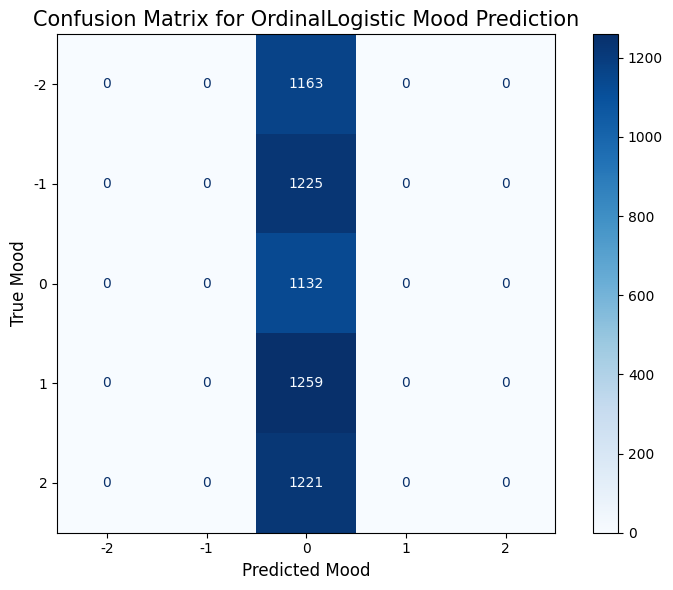

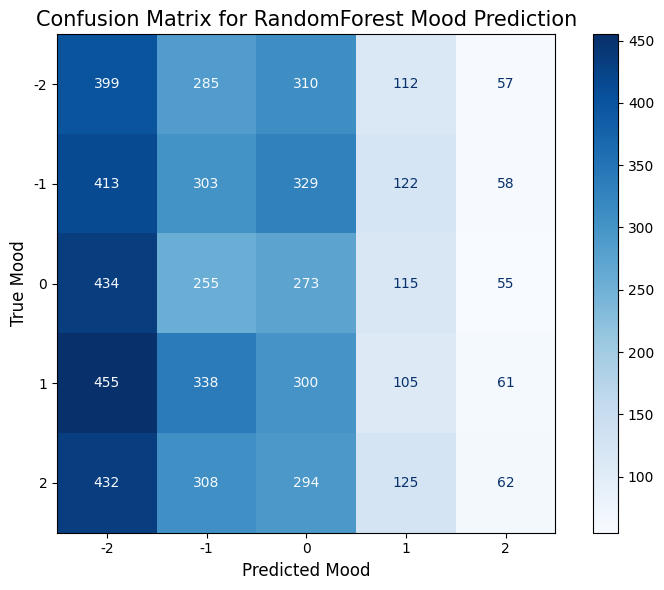

In [16]:
y_pred_ordinal = log_reg_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_ordinal = np.clip(np.round(y_pred_ordinal), -2, 2).astype(int)

def generate_confusion_matrix(y_test, y_pred, model_name):
    # Get unique classes from both test and predicted values
    unique_values = np.unique(np.concatenate([y_test, y_pred]))
    unique_values.sort()
    cm = confusion_matrix(y_test, y_pred, labels=unique_values)
    display_labels = [str(val) for val in unique_values]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')

    plt.title(f'Confusion Matrix for {model_name} Mood Prediction', fontsize=15)
    plt.ylabel('True Mood', fontsize=12)
    plt.xlabel('Predicted Mood', fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return cm

cm_ordinal = generate_confusion_matrix(y_test, y_pred_ordinal, "OrdinalLogistic")
cm_rf = generate_confusion_matrix(y_test, y_pred_rf, "RandomForest")

In [17]:
def generate_performance_metrics(y_test, y_pred, model_name=""):
    score = accuracy_score(y_test, y_pred)
    if model_name:
        print(f"\n=== {model_name} Performance ===")
    print('Model Accuracy:', score)
    print('Classification Report:\n', classification_report(y_test, y_pred, zero_division=0))
    
    return score

y_pred_ordinal = log_reg_model.predict(X_test)
y_pred_ordinal = np.clip(np.round(y_pred_ordinal), -2, 2).astype(int)
generate_performance_metrics(y_test, y_pred_ordinal, "OrdinalLogistic")
generate_performance_metrics(y_test, y_pred_rf, "Random Forest")


=== OrdinalLogistic Performance ===
Model Accuracy: 0.18866666666666668
Classification Report:
               precision    recall  f1-score   support

          -2       0.00      0.00      0.00      1163
          -1       0.00      0.00      0.00      1225
           0       0.19      1.00      0.32      1132
           1       0.00      0.00      0.00      1259
           2       0.00      0.00      0.00      1221

    accuracy                           0.19      6000
   macro avg       0.04      0.20      0.06      6000
weighted avg       0.04      0.19      0.06      6000


=== Random Forest Performance ===
Model Accuracy: 0.19033333333333333
Classification Report:
               precision    recall  f1-score   support

          -2       0.19      0.34      0.24      1163
          -1       0.20      0.25      0.22      1225
           0       0.18      0.24      0.21      1132
           1       0.18      0.08      0.11      1259
           2       0.21      0.05      0.08     

0.19033333333333333

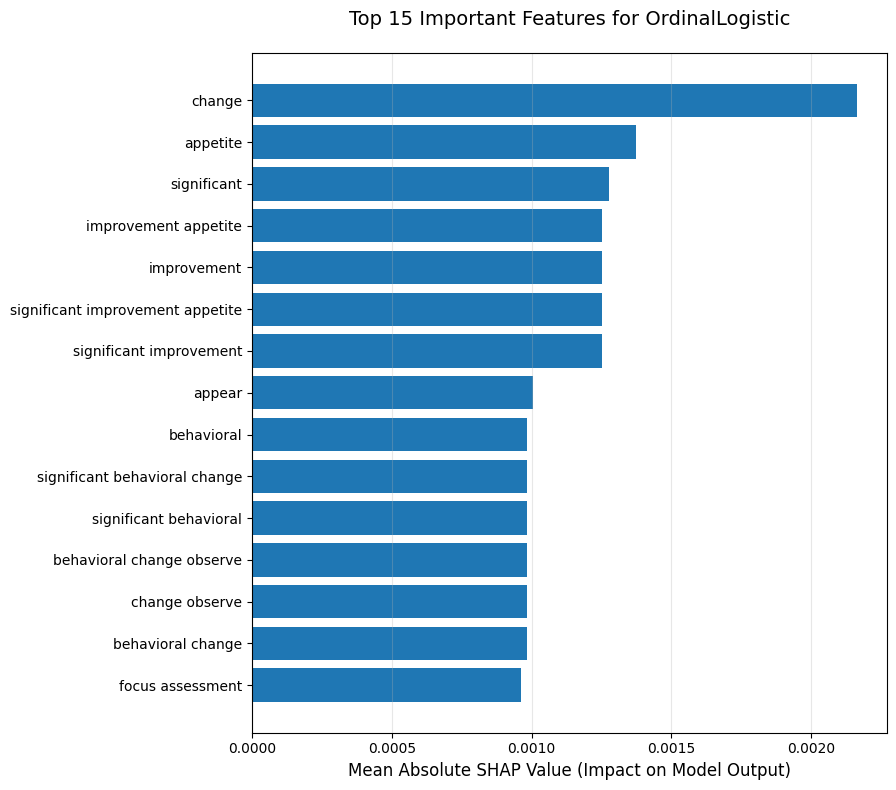

In [18]:
def plot_feature_importance(model, X_train, feature_names, model_name, max_features=15):
    if sparse.issparse(X_train):
        X_train = X_train.toarray()
    
    if str(model.__class__).endswith("OrdinalRidge'>"):
        explainer = shap.LinearExplainer(model, X_train)
    else:
        explainer = shap.TreeExplainer(model)
    
    shap_values = explainer.shap_values(X_train)
    if isinstance(shap_values, list):
        shap_values = np.abs(shap_values).mean(0) 
    else:
        shap_values = np.abs(shap_values)
    
    # Calculate mean importance
    mean_shap = np.mean(shap_values, axis=0)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': mean_shap
    }).sort_values('importance', ascending=True).tail(max_features) 
    
    plt.figure(figsize=(10, 8))
    bars = plt.barh(
        importance_df['feature'],
        importance_df['importance'],
        color='#1f77b4'
    )
    
    plt.xlabel('Mean Absolute SHAP Value (Impact on Model Output)', fontsize=12)
    plt.title(f'Top {max_features} Important Features for {model_name}', fontsize=14, pad=20)
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.35) 
    
    plt.show()

plot_feature_importance(log_reg_model, X_train, feature_names, "OrdinalLogistic")

 98%|===================| 29484/30000 [00:22<00:00]        


Analysis for output 1


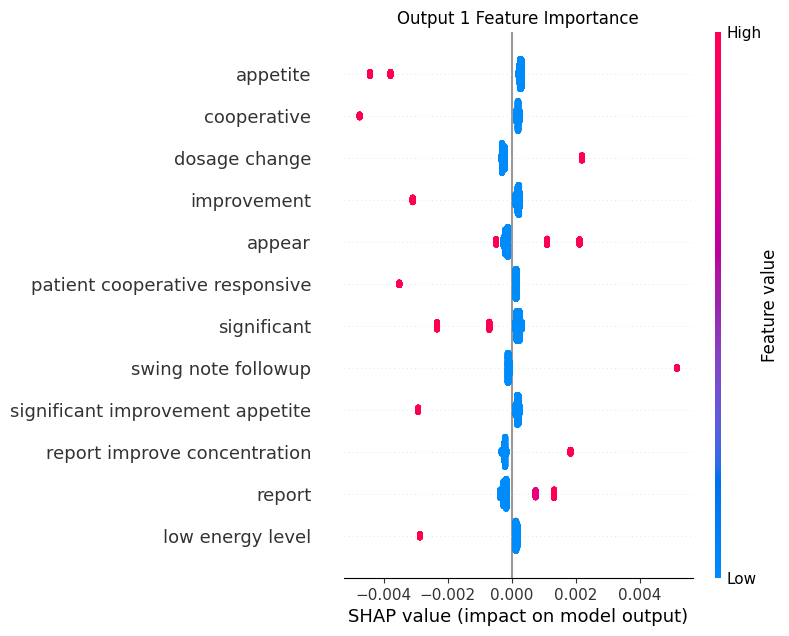


Analysis for output 2


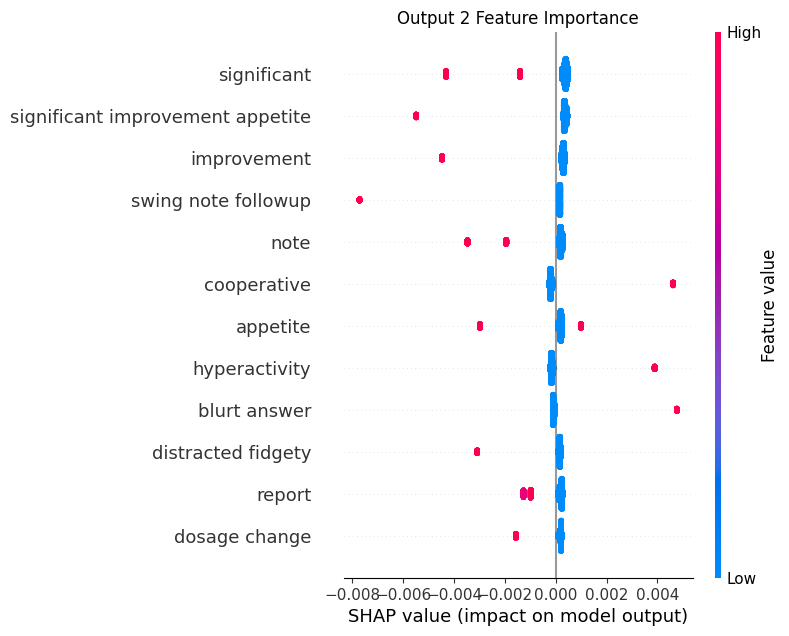


Analysis for output 3


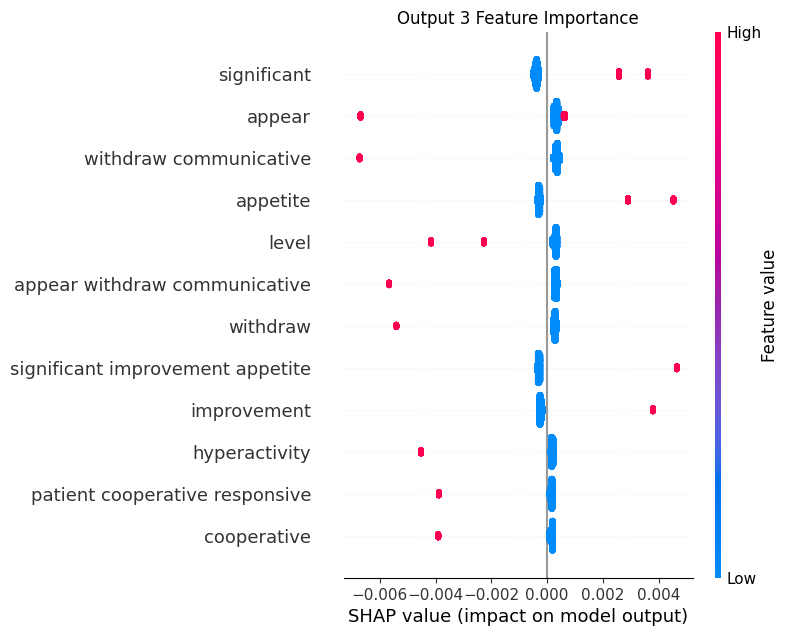


Analysis for output 4


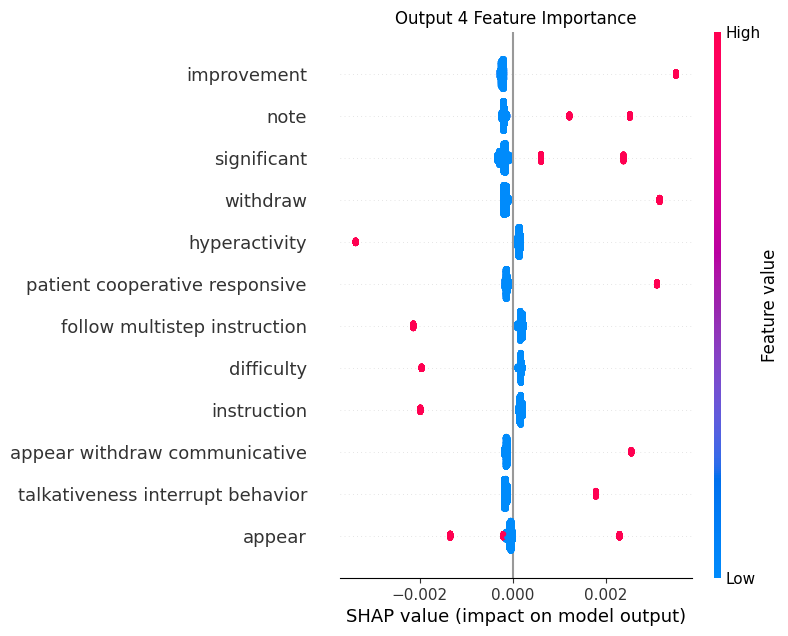


Analysis for output 5


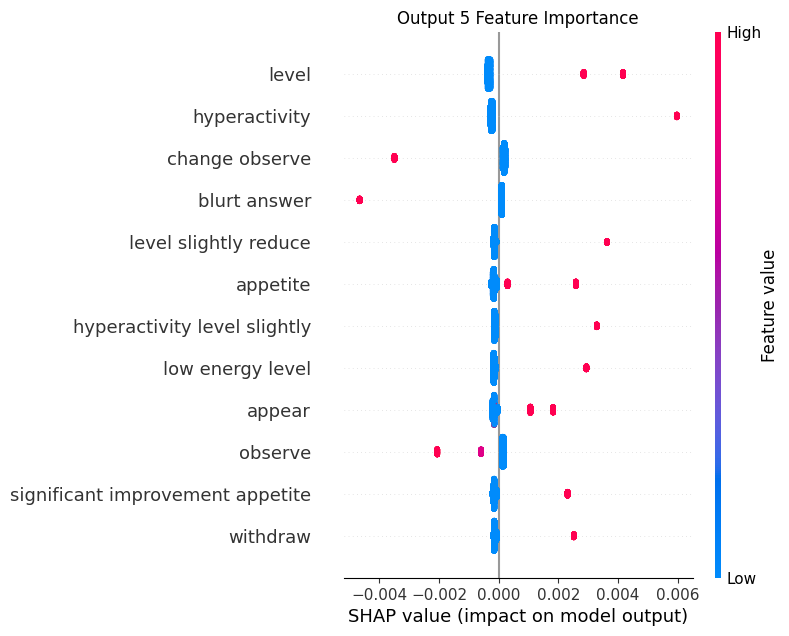

In [19]:
# compute SHAP values
explainer = shap.Explainer(rf_model, X_test, feature_names=feature_names)
shap_values = explainer(X_test)
for output_idx in range(shap_values.shape[-1]):
    print(f"\nAnalysis for output {output_idx+1}")
    shap.summary_plot(shap_values[..., output_idx], X_test, 
                     max_display=12, show=False)
    plt.title(f"Output {output_idx+1} Feature Importance")
    plt.show()